In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random
%matplotlib inline

# Build VM Demand Model

For the VM Packing environments, we're using Azure VM data provided by [Cortez et al.](https://github.com/Azure/AzurePublicDataset) ([paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2017/10/Resource-Central-SOSP17.pdf)). The data contains VM utilization from a Microsoft Azure data center over a 30-day period in 2019 at 5-minute intervals. Each VM instance must be assigned to a physical machine (PM) in the data center within its limits. We assume each i identical and PM has 30 cores and 70 GB's of RAM available. The values in our demand model are normalized to reflect these assumptions.

In [223]:
# Load data
url_vm_table = 'https://azurecloudpublicdataset2.blob.core.windows.net/azurepublicdatasetv2/trace_data/vmtable/vmtable.csv.gz'
url_mem_data = 'https://azurecloudpublicdataset2.blob.core.windows.net/azurepublicdatasetv2/azure2019_data/memory.txt'
url_core_data = 'https://azurecloudpublicdataset2.blob.core.windows.net/azurepublicdatasetv2/azure2019_data/cores.txt'
url_cpu_data = 'https://azurecloudpublicdataset2.blob.core.windows.net/azurepublicdatasetv2/azure2019_data/cpu.txt'

memory_data = pd.read_csv(url_mem_data, header=0, sep='\t')
core_data = pd.read_csv(url_core_data, header=0, sep='\t')
cpu_data = pd.read_csv(url_cpu_data, header=0, sep='\t')
max_mem = memory_data['vmmemorybucket'].max()
max_core = core_data['vmcorecountbucket'].max()
print('Max Memory:\t{}'.format(max_mem))
print('Max Core Count:\t{}'.format(max_core))

df_schema = pd.read_csv('https://azurecloudpublicdataset2.blob.core.windows.net/azurepublicdatasetv2/schema.csv')
col_names = df_schema.loc[df_schema['filepattern']=='vmtable/vmtable.csv.gz']['content'].values
df = pd.read_csv('vmtable.csv', header=None, index_col=False)
df.columns = col_names
df['vm virtual core count bucket'] = df['vm virtual core count bucket'].replace(
    '>24', max_core).astype(int)
df['vm memory (gb) bucket'] = df['vm memory (gb) bucket'].replace(
    '>64', max_mem).astype(int)
df.head()

Max Memory:	70
Max Core Count:	30


,vm id,subscription id,deployment id,timestamp vm created,timestamp vm deleted,max cpu,avg cpu,p95 max cpu,vm category,vm virtual core count bucket,vm memory (gb) bucket
0,71fJw0x+SDRdAxKPwLyHZhTgQpYw2afS6tjJhfT6kHnmLH...,GB6uQC1NSArW5n+TtOybL7GQ1yByjuWtZnsj+5QccZ525R...,2sh/ZjaYdfpslv4iYBfNzFe4rs982kHVvNGJGeQ8MIBCDr...,558300,1673700,91.776885,0.728879,20.759630,Delay-insensitive,8,32
1,rKggHO/04j31UFy65mDTwtjdMQL/G03xWfl3xGeiilB4/W...,ub4ty8ygwOECrIz7eaZ/9hDwnCsERvZ3nJJ03sDSpD85et...,+ZraIDUNaWYDZMBiBtZm7xSjr+j3zcHGjup1+wyKxHFmyJ...,424500,425400,37.879261,3.325358,37.879261,Unknown,4,32
2,YrR8gPtBmfNaOdnNEW5If1SdTqQgGQHEnLHGPjySt53bKW...,9LrdYRcUfGbmL2fFfLR/JUg2OTkjGRe3iluwIhDRPnPDPa...,GEyIElfPSFupze8T+T1niQMepeqG88VpLNuxUMyIDbz8VF...,1133100,1133700,0.304368,0.220553,0.304368,Unknown,4,32
3,xzQ++JF1UAkh70CDhmzkiOo+DQn+E2TLErCFKEmSswv1pl...,0XnZZ8sMN5HY+Yg+0dykYB5oenlgsrCpzpgFSvn/MX42Ze...,7aCQS6fPUw9rwCPiqvghk/WCEbMV3KgNJjA+sssdfY5Ybl...,0,2591400,98.573424,30.340054,98.212503,Interactive,2,4
4,vZEivnhabRmImDr+JqKqZnpIM3WxtypwoxjfjnklR/idyR...,HUGaZ+piPP4eHjycCBki2yq0raJywdzrVuriR6nQceH3hA...,/s/D5VtTQDxyS6wq7N/VQAMczx61Ny1Ut3a3iFmDSOCXxp...,228300,229800,82.581449,13.876299,82.581449,Unknown,2,4


In [3]:
# Map t to t_
n = 30
t = np.linspace(0, 24*n*60, int((24*n*60)/5 + 1)).astype(int)
t_ = np.linspace(0, 24*60, int((24*60) / 5 + 1)).astype(int)
a = np.vstack(np.unique(t % 1445, return_counts=True))
print(np.allclose(t_, a[0]))
print(a[:,np.argmin(a[1])])
print(a[:,np.argmax(a[1])])

True
[1300   29]
[ 0 30]


Our simulation runs for only one day. We map each VM time stamp to a 5-minute interval in a 24-hour period. More accurate models could be built by accounting for weekly regularities (e.g. difference in demand on a Saturday versus a Tuesday).

In [4]:
t = df['timestamp vm created'].values
a = np.vstack(np.unique(t % 1445, return_counts=True))
print(np.allclose(t_, a[0]))
print('Least frequent time interval and count: {}'.format(a[:,np.argmin(a[1])]))
print('Most frequent time interval and count: {}'.format(a[:,np.argmax(a[1])]))
print('Mean count: {:.1f}'.format(a[1].mean()))

True
Least frequent time interval and count: [ 170 6740]
Most frequent time interval and count: [     0 236617]
Mean count: 9327.2


There seems to be an incredibly common time interval in the data that occurs ~25X more often than average. This appears to be caused by long-running processes that began before $t=0$ and persisted for over 30 days. For our purposes, we can remove these processes from the data. These points account for roughly 7% of our data.

In [39]:
df = df.loc[~((df['timestamp vm created']==0) &
       (df['timestamp vm deleted']==df['timestamp vm deleted'].max()))]
df.shape

(2516307, 11)

In [270]:
df['start_interval'] = df['timestamp vm created'] % 1445
df['end_interval'] = df['timestamp vm deleted'] % 1445
# Cap runs at end of day
# Apply function takes some time...
df['duration'] = df['end_interval'] - df['start_interval']
df['duration'] = df.apply(
    lambda x: 1440 - x['start_interval'] 
    if x['duration'] <= 0 
    else x['duration'], 
    axis=1)

In [76]:
# Normalize vm memory and core to max values
df['vm virtual core count bucket'] = df['vm virtual core count bucket'] / max_core
df['vm memory (gb) bucket'] = df['vm memory (gb) bucket'] / max_mem
stats = ['mean', 'std']
vm_start_stats = df.groupby('start_interval').agg(
    {'avg cpu': stats,
     'vm virtual core count bucket': stats,
     'vm memory (gb) bucket': stats,
     'duration': stats})

vm_start_stats.columns = [(i + ' ' + j).replace(' ', '_') 
       for i in vm_start_stats.columns.levels[0] 
       for j in vm_start_stats.columns.levels[1]]
vm_start_stats.reset_index(inplace=True)

In [77]:
vm_start_stats

,start_interval,avg_cpu_mean,avg_cpu_std,vm_virtual_core_count_bucket_mean,vm_virtual_core_count_bucket_std,vm_memory_(gb)_bucket_mean,vm_memory_(gb)_bucket_std,duration_mean,duration_std
0,0,11.527755,15.933265,0.111685,0.105013,0.190405,0.198678,727.443530,415.746919
1,5,15.006879,18.226063,0.123111,0.134695,0.221368,0.212622,715.816809,409.805460
2,10,13.853713,18.219211,0.137778,0.142075,0.267207,0.220499,690.361217,391.972534
3,15,14.395619,19.021460,0.140275,0.156631,0.259767,0.226629,700.328147,400.091791
4,20,15.240466,18.864898,0.125638,0.138838,0.236256,0.216630,667.228829,399.699261
...,...,...,...,...,...,...,...,...,...
284,1420,14.332753,17.599766,0.128241,0.141187,0.242896,0.217058,19.982517,0.491724
285,1425,14.540309,18.119114,0.140720,0.155322,0.258016,0.229170,14.994340,0.231143
286,1430,17.314880,20.492887,0.127667,0.130357,0.240813,0.209577,9.994872,0.160056
287,1435,17.612615,20.177541,0.130620,0.157034,0.241149,0.223693,5.000000,0.000000


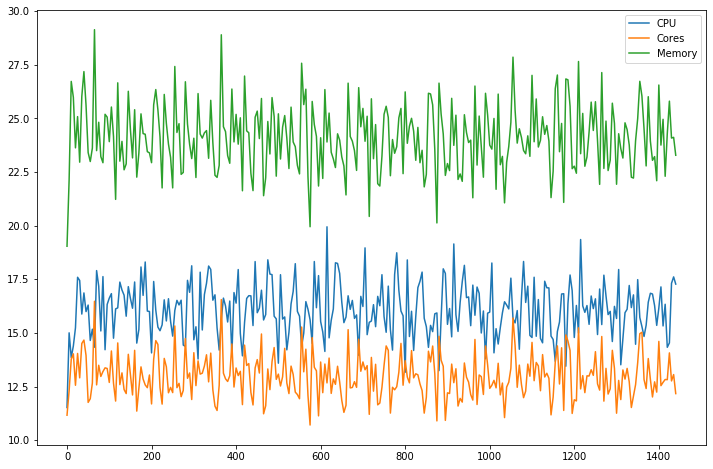

In [81]:
plt.figure(figsize=(12,8))
plt.plot(vm_start_stats['start_interval'], 
         vm_start_stats['avg_cpu_mean'], label='CPU')
plt.plot(vm_start_stats['start_interval'], 
         vm_start_stats['vm_virtual_core_count_bucket_mean']*100, label='Cores')
plt.plot(vm_start_stats['start_interval'], 
         vm_start_stats['vm_memory_(gb)_bucket_mean']*100, label='Memory')
plt.legend()
plt.show()

In [154]:
from scipy.optimize import leastsq

def gaussian(params, x):
    return params[2] * np.exp(-0.5*((x - params[0]) / params[1]) ** 2) + params[3]

def ols(params, x, y):
    return y - gaussian(params, x)

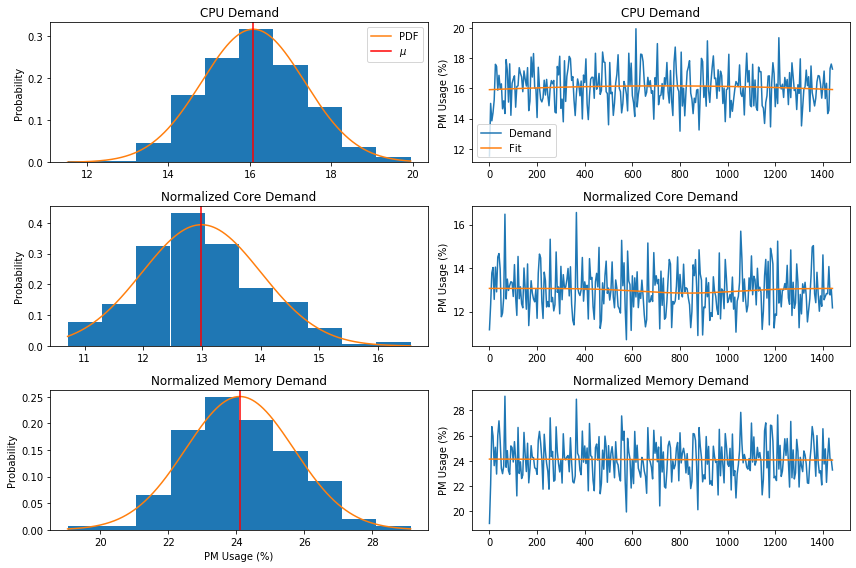

In [200]:
vals = ['avg_cpu_mean', 'vm_virtual_core_count_bucket_mean', 'vm_memory_(gb)_bucket_mean']
titles = {'avg_cpu_mean': 'CPU Demand',
          'vm_virtual_core_count_bucket_mean': 'Normalized Core Demand',
          'vm_memory_(gb)_bucket_mean': 'Normalized Memory Demand'}
init = [1, 1, 1, 1]
x_axis = vm_start_stats.index * 5
fig, ax = plt.subplots(len(vals), 2, figsize=(12,8))
for i, v in enumerate(vals):
    val = vm_start_stats[v].values * 100 if v != 'avg_cpu_mean' else vm_start_stats[v].values
    mu = val.mean()
    sigma = val.std()
    xdata = np.linspace(val.min(), val.max(), 1000)
    pdf_y = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*((xdata-mu)/sigma)**2)

    ax[i, 0].hist(val, density=True)
    ax[i, 0].plot(xdata, pdf_y, label='PDF')
    ax[i, 0].axvline(mu, color='r', label=r'$\mu$')
    ax[i, 0].set_ylabel('Probability')
    ax[i, 0].set_title(titles[v])
    
    xdata = np.linspace(0, 1, len(val))
    opt_params = leastsq(ols, init, args=(xdata, val))
    y_hat = gaussian(opt_params[0], xdata)
    
    ax[i, 1].plot(x_axis, val, label='Demand')
    ax[i, 1].plot(x_axis, y_hat, label='Fit')
    ax[i, 1].set_ylabel('PM Usage (%)')
    ax[i, 1].set_title(titles[v])
    
ax[-1, 0].set_xlabel('PM Usage (%)')
ax[0, 0].legend()
ax[0, 1].legend()
plt.tight_layout()
plt.show()

The demand data for each of the three parameters fit a Gaussian distribution well. There don't appear to be any significant patterns in the time series. As a result, we'll draw from a Gaussian distribution to determine the demand for each of our simulations based on the parameters given by the data.

In [201]:
mu_cpu = vm_start_stats['avg_cpu_mean'].mean()
sigma_cpu = vm_start_stats['avg_cpu_mean'].std()
mu_core = vm_start_stats['vm_virtual_core_count_bucket_mean'].mean()
sigma_core = vm_start_stats['vm_virtual_core_count_bucket_mean'].std()
mu_mem = vm_start_stats['vm_memory_(gb)_bucket_mean'].mean()
sigma_mem = vm_start_stats['vm_memory_(gb)_bucket_mean'].std()

In [224]:
mem_probs = memory_data['value'].values
mem_probs[0] = 12 # Round down to ensure vals sum to 1
mem_probs /= 100
mem_bins = memory_data['vmmemorybucket'].values / max_mem
n = int(1440/5) + 1
demand = np.vstack([
    np.random.normal(loc=mu_cpu, scale=sigma_cpu, size=n),
    np.random.choice(mem_bins, p=mem_probs, size=n)])

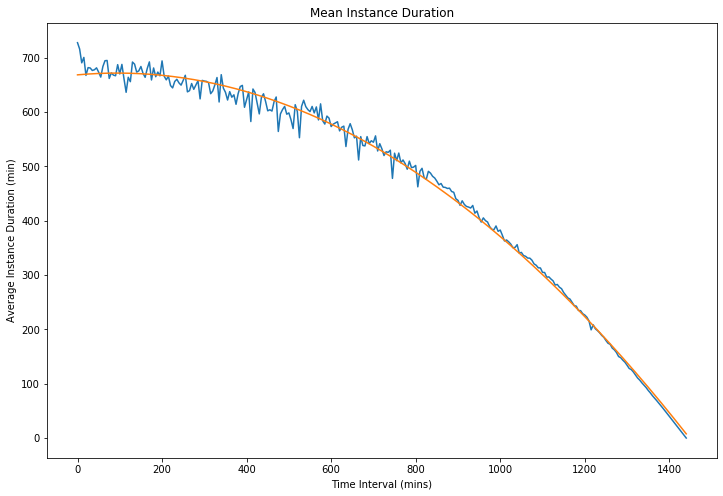

In [235]:
init = [6.5e-2, 3.4, 1.7e6, -1.7e6]
durations = vm_start_stats['duration_mean']
xdata = np.linspace(0, 1, len(durations))
opt_params = leastsq(ols, init, args=(xdata, durations))
y_hat = gaussian(opt_params[0], xdata)

# Plot durations
plt.figure(figsize=(12,8))
plt.plot(vm_start_stats.index*5, vm_start_stats['duration_mean'])
plt.plot(vm_start_stats.index*5, y_hat)
plt.ylabel('Average Instance Duration (min)')
plt.xlabel('Time Interval (mins)')
plt.title('Mean Instance Duration')
plt.show()

In [236]:
opt_params

(array([ 6.53563303e-02,  5.16222242e+01,  4.05028032e+06, -4.04960880e+06]),
 1)

In [239]:
mu_cpu

16.08380121896948

In [240]:
sigma_cpu

1.2646023551454462

In [242]:
cpu_demand = np.random.normal(loc=mu_cpu, scale=sigma_cpu, size=n) / 100

In [260]:
def generate_demand():
    t_int = 5
    n = int(1440 / t_int) # 1 day, 5 minute intervals
    # From Azure data
    mem_probs = np.array([0.12 , 0.165, 0.328, 0.287, 0.064, 0.036])
    mem_bins = np.array([0.02857143, 0.05714286, 0.11428571, 0.45714286, 0.91428571,
       1.]) # Normalized bin sizes
    mu_cpu = 16.08
    sigma_cpu = 1.26
    cpu_demand = np.random.normal(loc=mu_cpu, scale=sigma_cpu, size=n)
    cpu_demand = np.where(cpu_demand<=0, mu_cpu, cpu_demand) # Ensure demand isn't negative
    mem_demand = np.random.choice(mem_bins, p=mem_probs, size=n)
    return np.vstack([cpu_demand/100, mem_demand]).T

In [261]:
x = generate_demand()

In [262]:
x[0]

array([0.17202027, 0.02857143])

In [292]:
def generate_durations(demand):
    # duration_params = np.array([ 6.53563303e-02,  5.16222242e+01,  4.05028032e+06, -4.04960880e+06])
    return {i: np.random.randint(low=i+1, high=len(demand)+1)
        for i, j in enumerate(demand)}

In [293]:
durs = generate_durations(x)

In [300]:
state = (np.zeros((100, 3)), x[0])
pm_state = state[0]

In [298]:
print(durs[3])
for process in durs.keys():
    if durs[process] == 8:
        print(process)

8
3


In [287]:
step_count = 8
# Remove processes
if step_count in durs.values():
    for process in durs.keys():
        # Remove process from PM
        if self.durations[process] == self.step_count:
            pm = alist[process]
            pm_state[pm, self.load_idx] -= env.demand[process]
            # Shut down PM's if state is 0
            if pm_state[pm, self.load_idx].sum() == 0:
                pm_state[pm, 0] = 0

199.67026777895495

In [277]:
df['duration2'] = df['timestamp vm deleted'] - df['timestamp vm created']
df_short = df.loc[df['duration2']<=1500]
np.mean(df_short['duration2'])

642.6699400143594

In [278]:
np.std(df_short['duration2'])

430.9112693672041

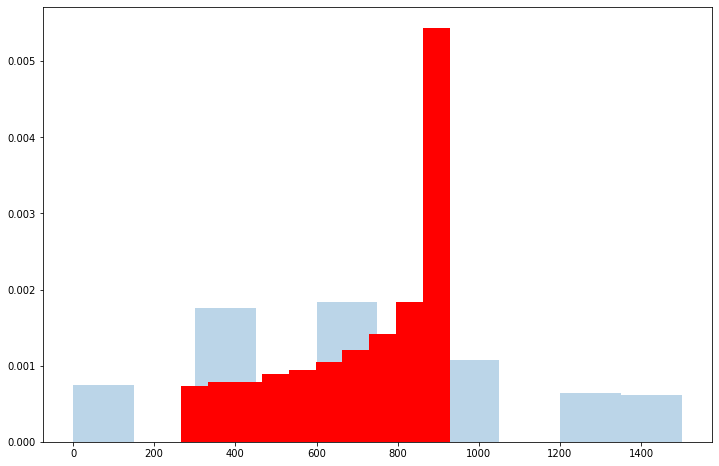

In [291]:
plt.figure(figsize=(12,8))
plt.hist(df_short['duration2'], alpha=0.3, density=True)
plt.hist(durs, color='r', density=True)
plt.show()